в папке data

Данные в файлах записаны в таком формате 
TICKER, PER, DATE, TIME, CLOSE, VOL

In [21]:
import matplotlib.pyplot as plt
import os
from datetime import datetime
import math

In [2]:
# Создаем папку для графиков, если её нет
if not os.path.exists('plots'):
    os.makedirs('plots')

In [3]:
# Получаем список всех файлов в папке data
data_files = os.listdir('data')

In [4]:
# Для каждого файла парсим его данные

DATA = []

for file_name in data_files:
    if file_name.endswith('.txt'):
        # Читаем файл
        file_path = os.path.join('data', file_name)
        
        dates = []
        close_prices = []
        ticker = file_name.split('_')[0]
        vol = []

        buffer = {
            'TICKER': ticker,
            'DATES': [],
            'CLOSE_PRICES': [],
            'VOLUMES': []
        }

        
        with open(file_path, 'r') as file:
            for line in file:
                # Разбиваем строку по запятой
                parts = line.strip().split(',')
                if len(parts) >= 6:  # Проверяем, что строка содержит все нужные данные
                    buffer['DATES'].append(datetime.strptime(parts[2], "%y%m%d"))
                    buffer['CLOSE_PRICES'].append(float(parts[4]))
                    buffer['VOLUMES'].append(float(parts[5]))

        DATA.append(buffer)

In [5]:
# Функция для построения графика

def plot_data(data):

    plt.figure(figsize=(12, 6))

    # Строим график
    plt.plot(data['DATES'], data['CLOSE_PRICES'], linewidth=1, color='red')

    # Настраиваем внешний вид графика
    plt.title(f"История цены закрытия - {data['TICKER']}")
    plt.xlabel('Дата')
    plt.ylabel('Цена закрытия')

    # Поворачиваем метки на оси X для лучшей читаемости
    plt.xticks(rotation=45)

    # Добавляем сетку
    plt.grid(True, linestyle='--', alpha=0.7)

    # Настраиваем расположение элементов
    plt.tight_layout()

    # Показываем график
    plt.show() 

Нарисуем все графики цен закрытия

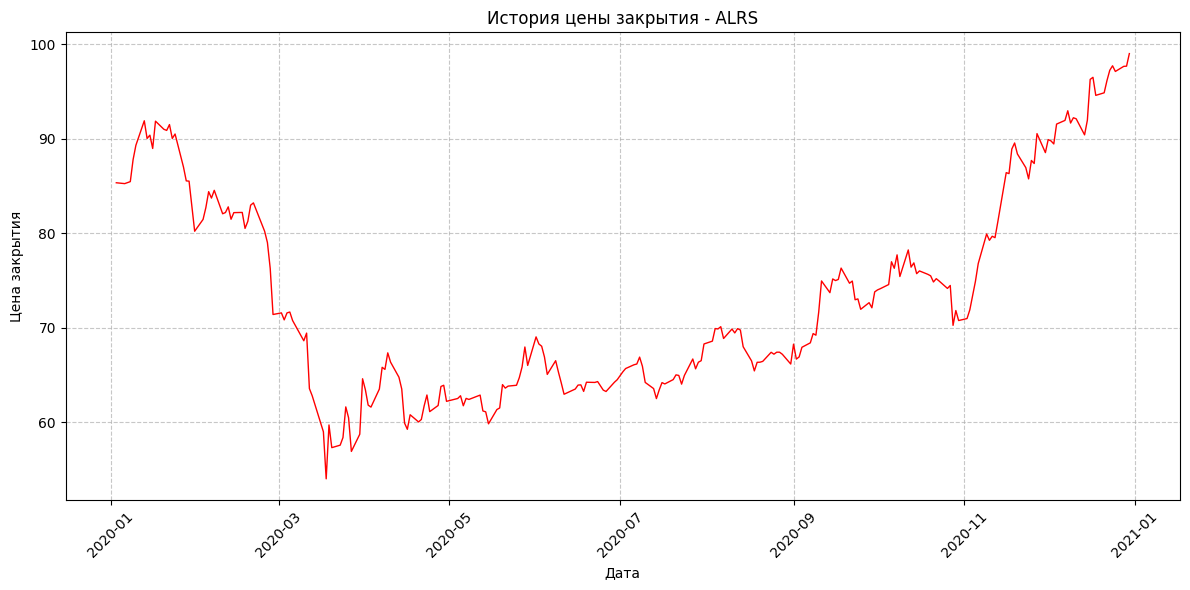

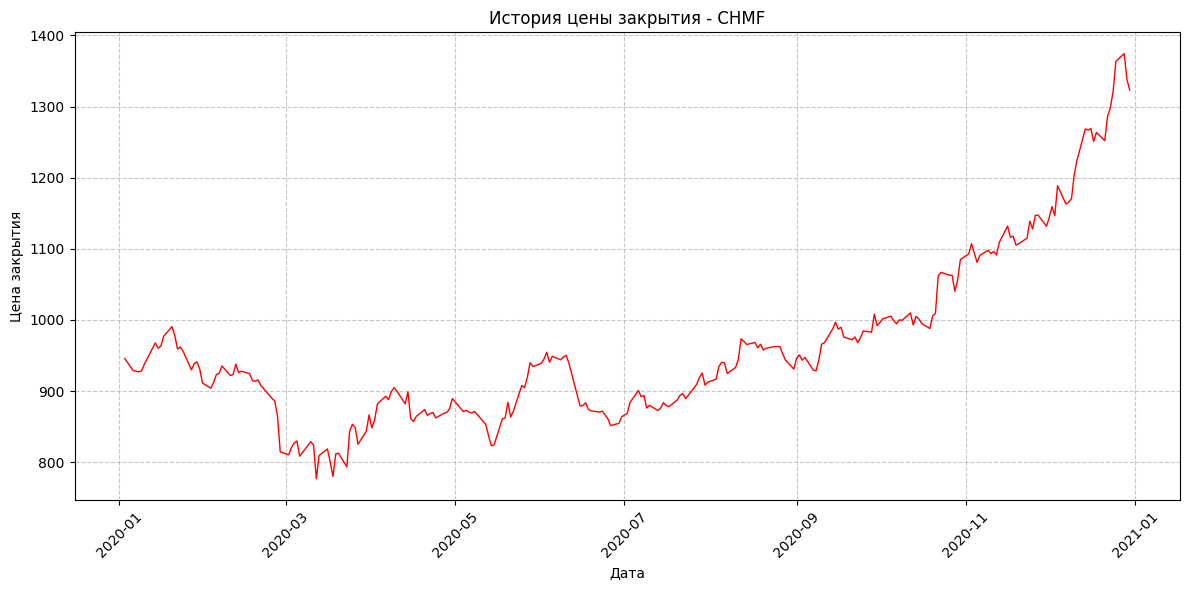

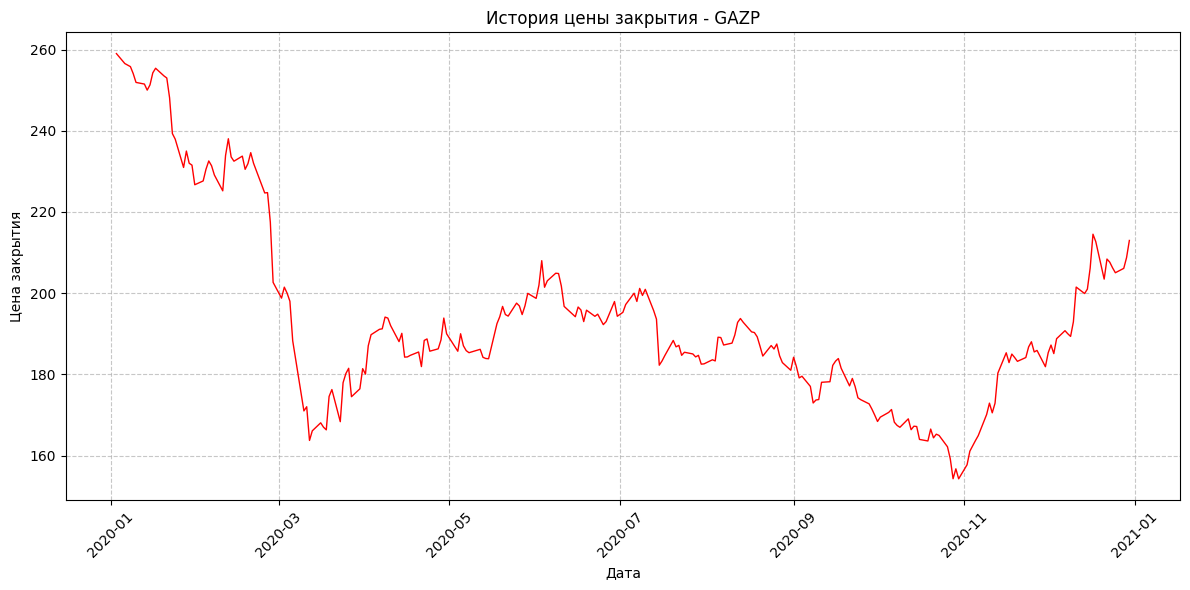

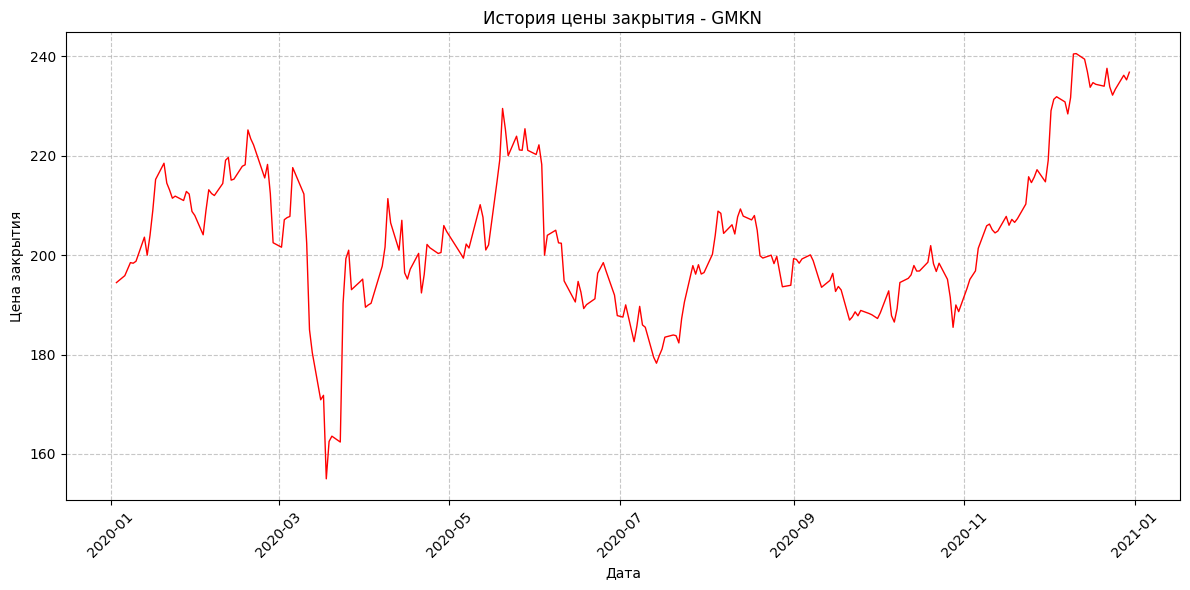

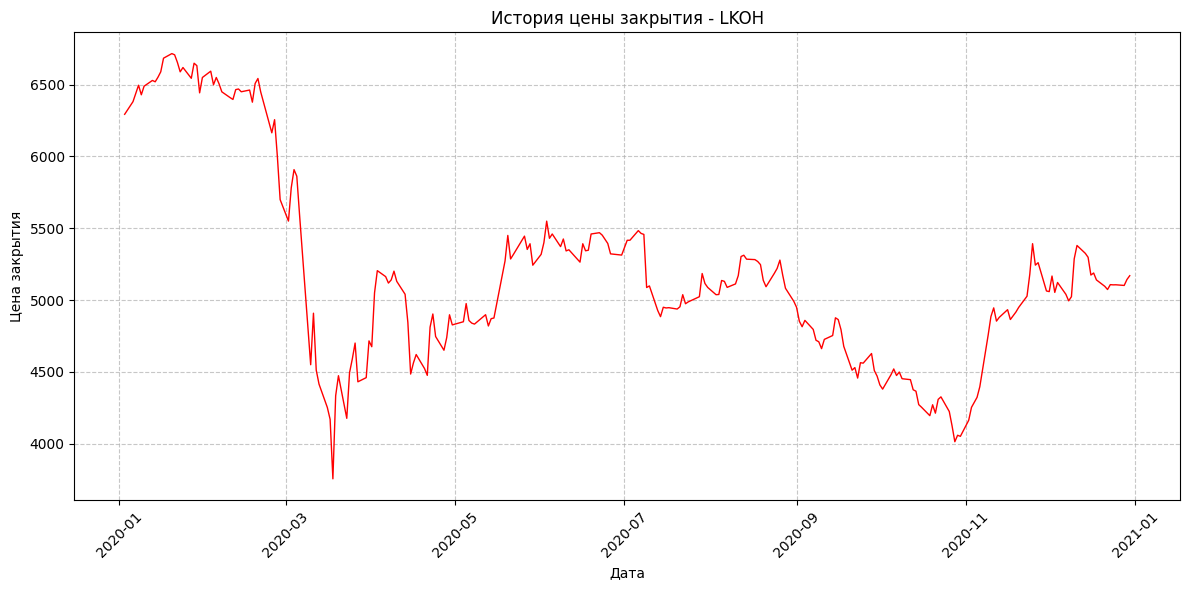

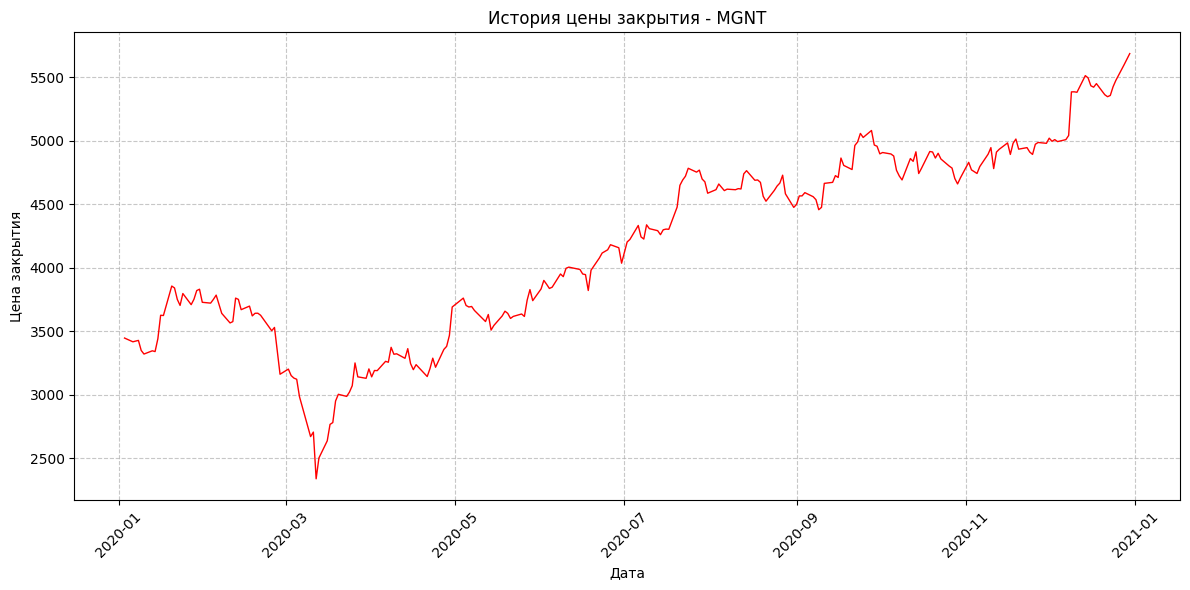

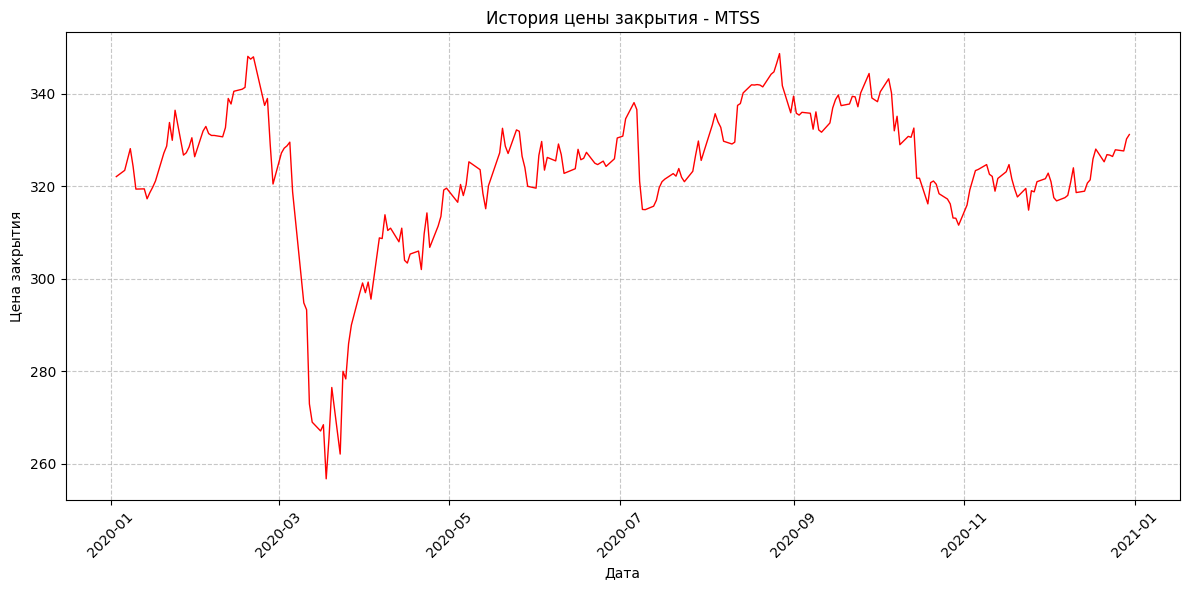

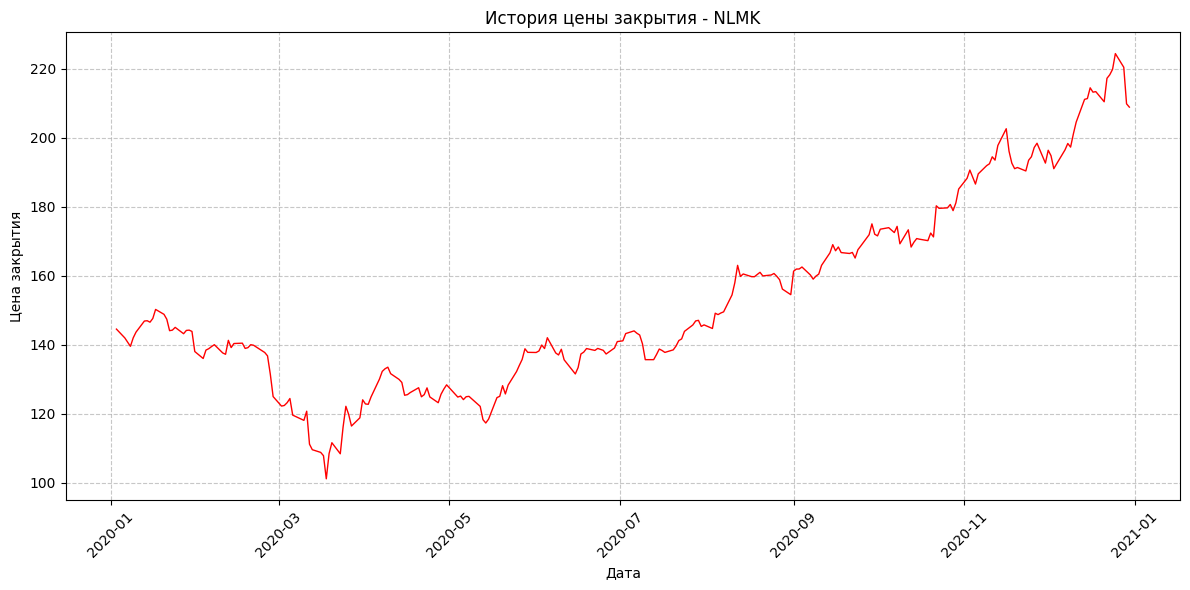

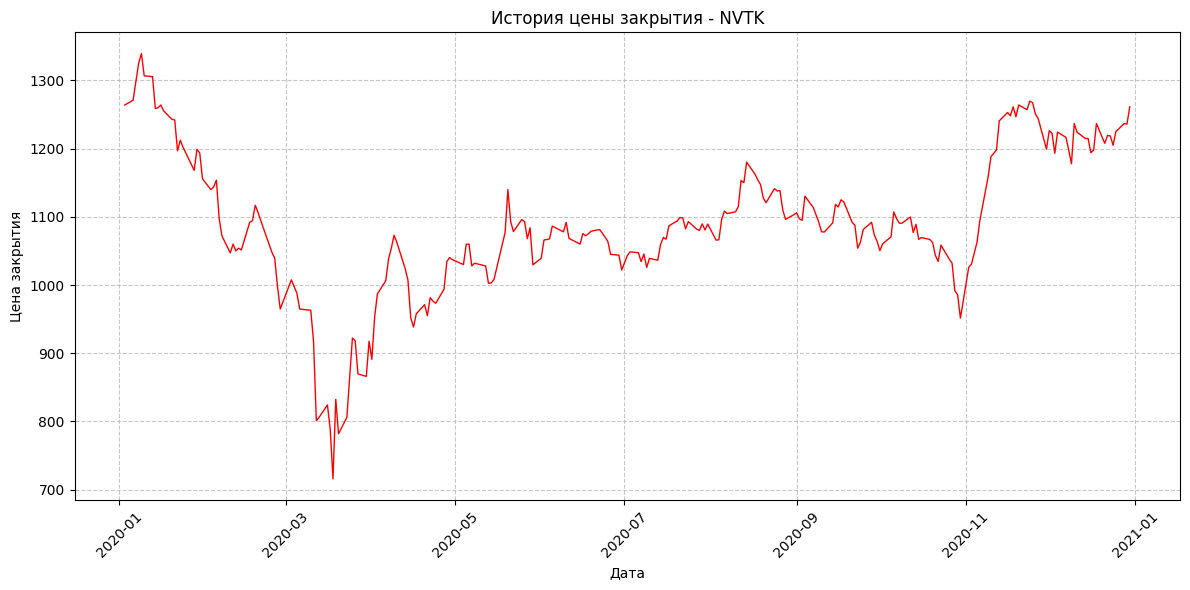

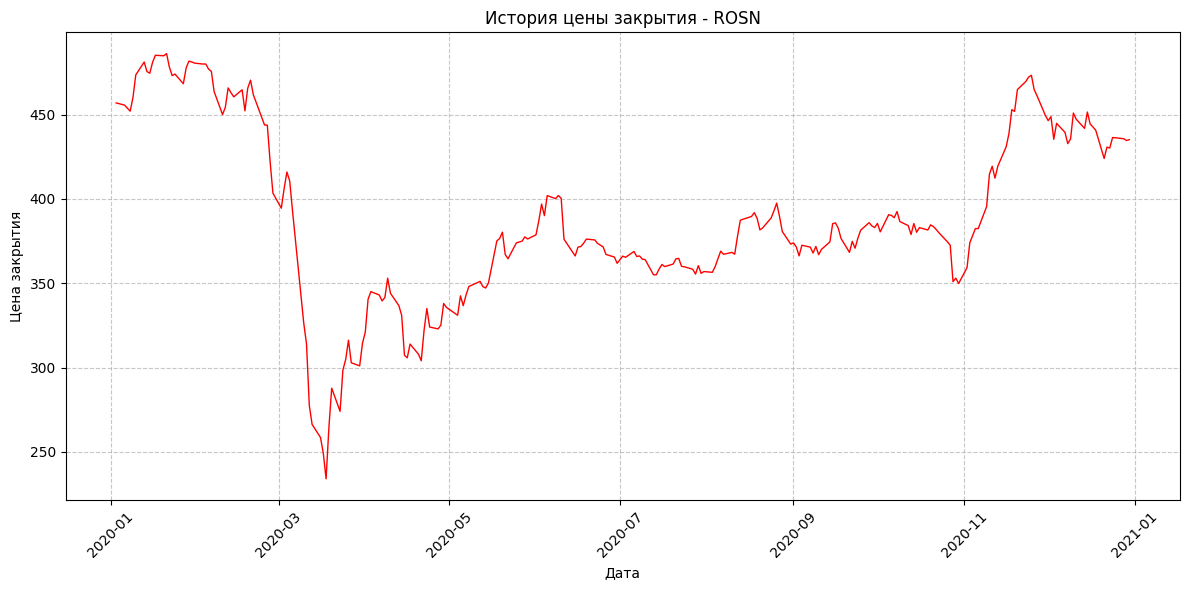

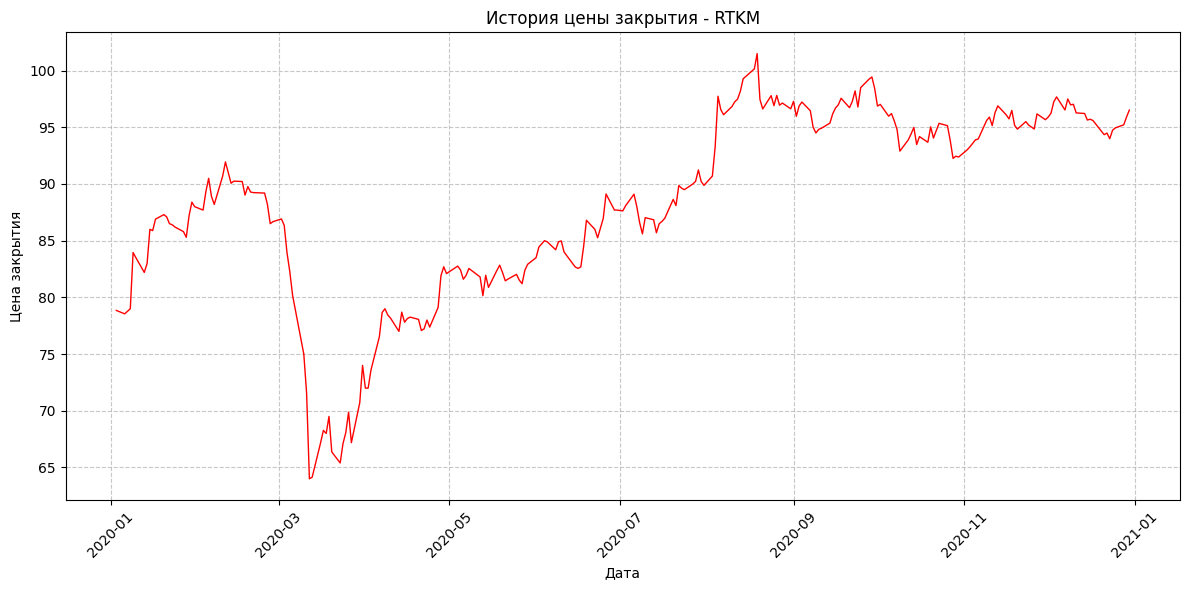

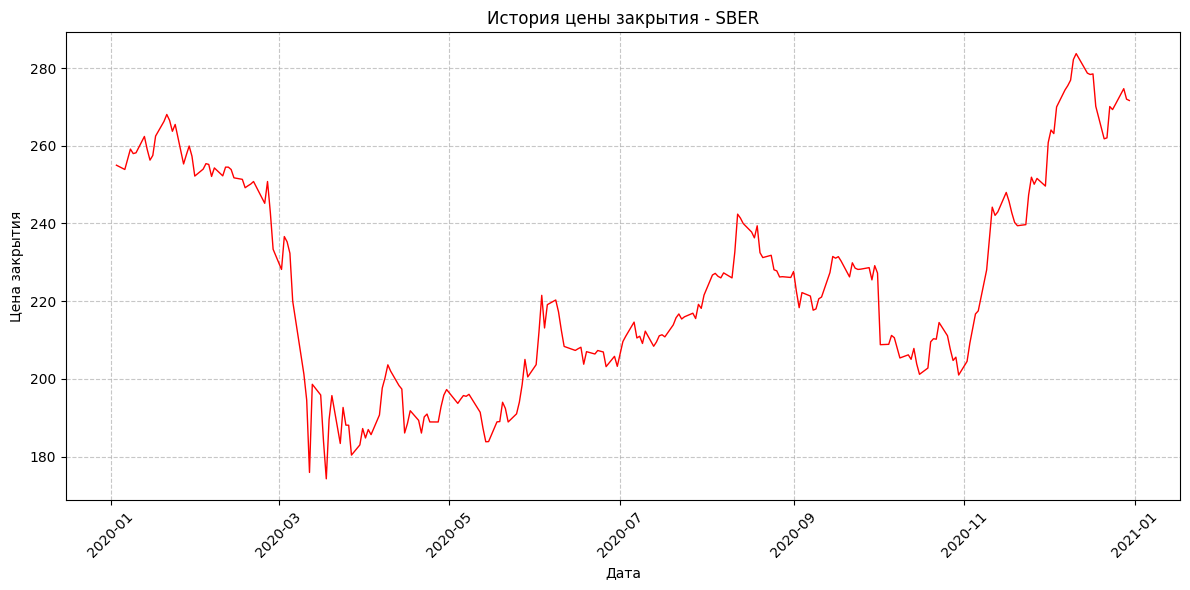

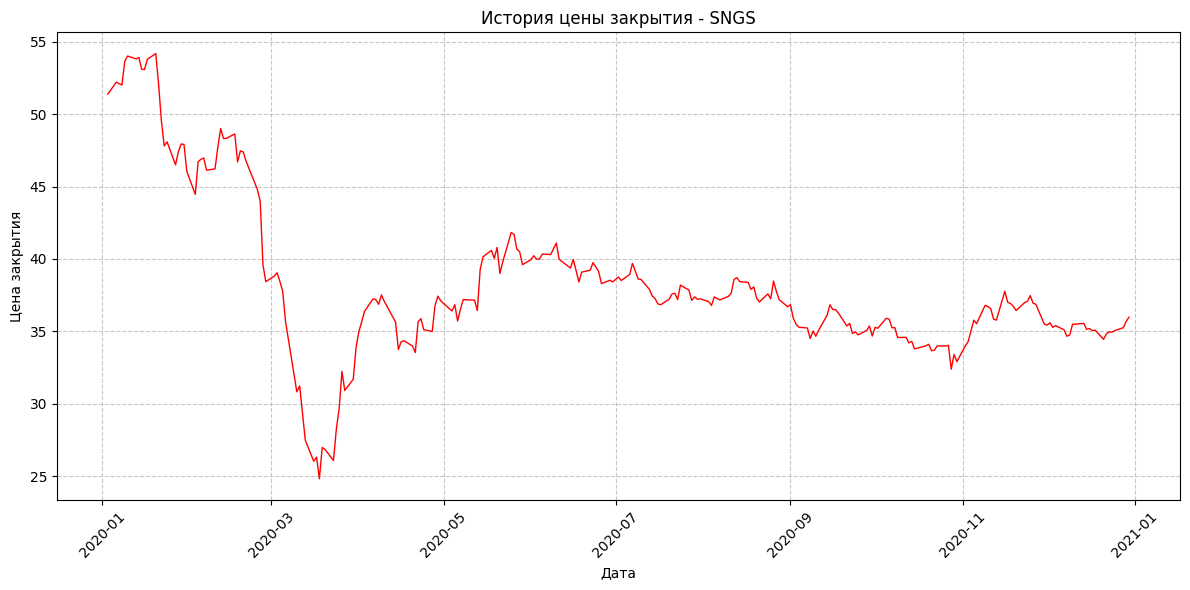

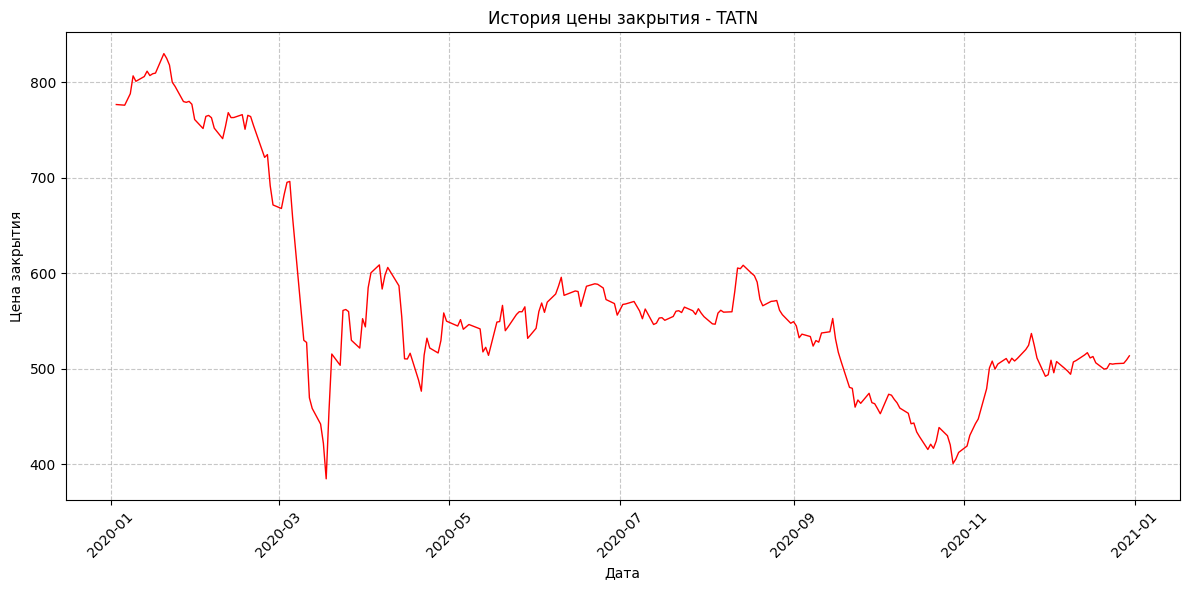

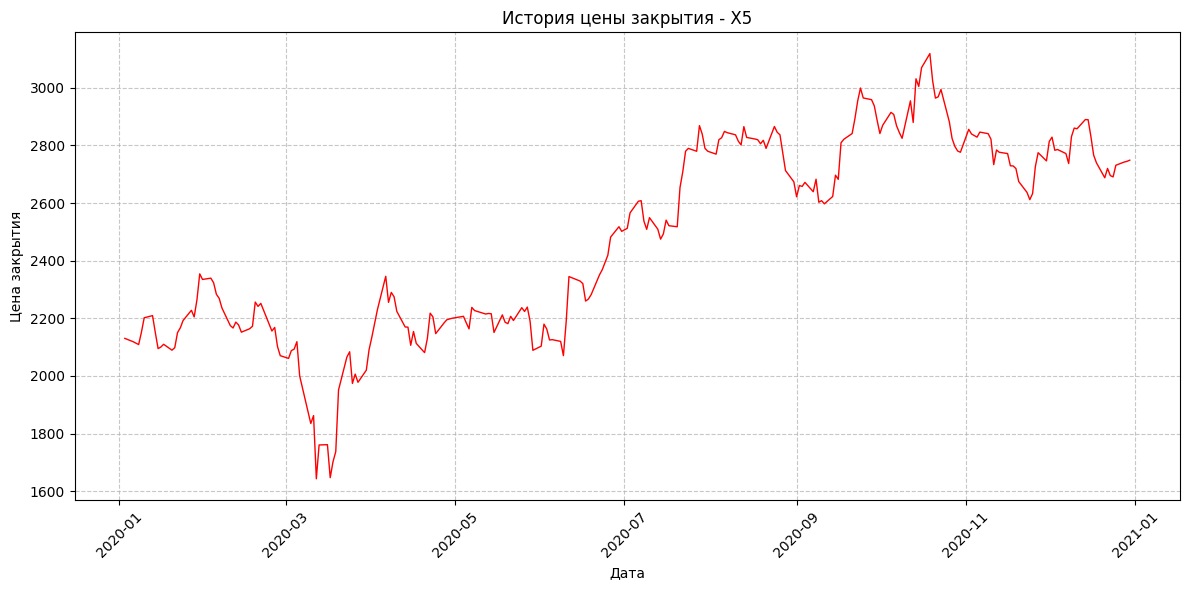

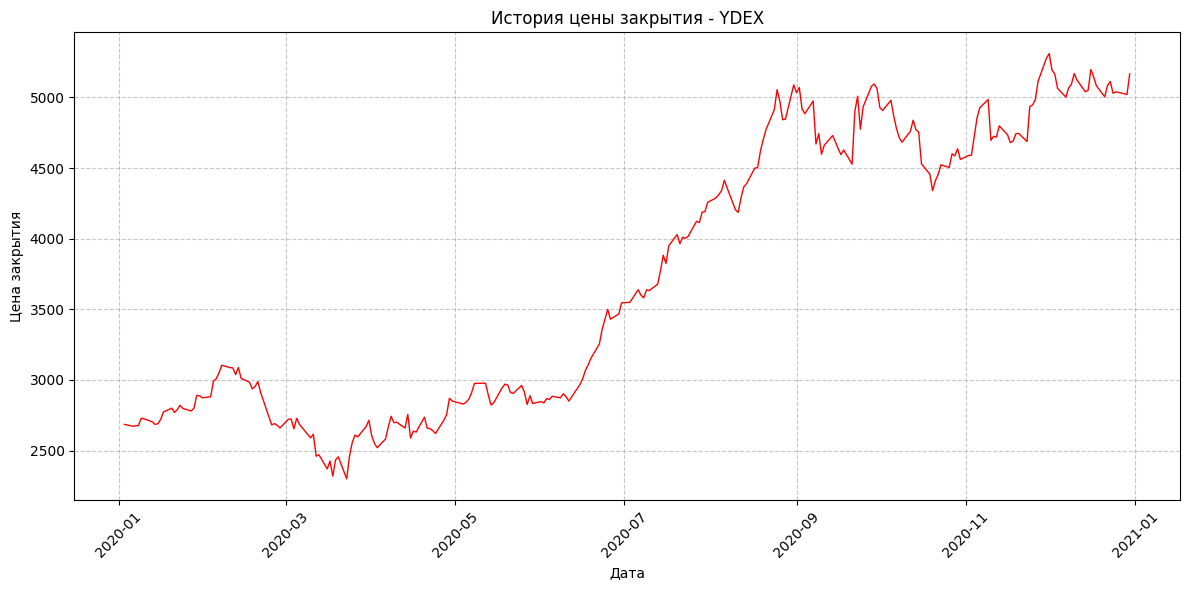

In [6]:
for data in DATA:
    plot_data(data)

Реализуем рассчет метрики кластеризации

In [7]:
def calculate_sma(values, window):
    """
    Рассчитывает простую скользящую среднюю (SMA) для списка значений.
    
    Args:
        values (list): Список числовых значений
        window (int): Размер окна (количество дней)
    
    Returns:
        list: Список значений SMA
    """
    if not values or window <= 0:
        return []
    
    if window > len(values):
        return []
    
    sma_values = []
    for i in range(window - 1, len(values)):
        window_values = values[i - window + 1 : i]
        sma = sum(window_values) / window
        sma_values.append(sma)
    
    return sma_values

Отрисовка графиков как виджетов

%matplotlib widget

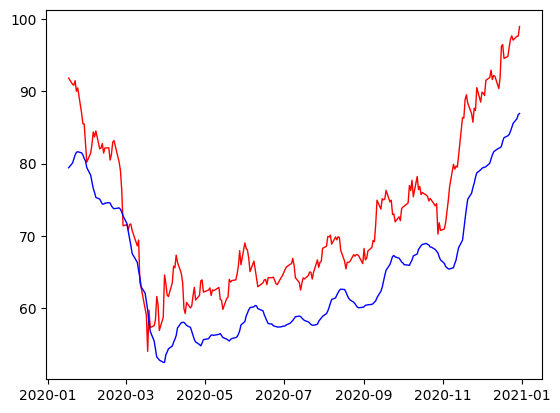

In [8]:
plt.plot(DATA[0]['DATES'][9::], DATA[0]['CLOSE_PRICES'][9::], color='red', linewidth=1)
plt.plot(DATA[0]['DATES'][9::], calculate_sma(DATA[0]['CLOSE_PRICES'], 10), color='blue', linewidth=1)
plt.show()

Рассчет гамма метрики

In [15]:
def gamma_metric(mean, real):
    """
    Вычисляет гамма метрики для ряда данных
    
    Parameters
    ----------
    mean : list
        Значения скользящего среднего в моменте времени t
    real : list
        Значения элемента ряда в момент времени t
    Returns
    -------
    list
        Метрики
    
    Raises
    ------
    ValueError
        Если длины массивов не равны
    """
    
    # mean - Значение скользящего среднего в моменте времени t
    # real - Значение элемента ряда в момент времени t

    if(len(mean) != len(real)):
        raise ValueError("Mean and real must have the same length")
    
    gamma = []

    for i in range(len(mean) - 1):
        VNMi = (real[i + 1] - mean[i + 1]) / ( real[i]**2 + (real[i + 1] - mean[i + 1])**2 )**0.5
        gamma.append(VNMi)

    return gamma

In [16]:
gamma_metric([0,0,0], [1, 2, 3])

[0.8944271909999159, 0.8320502943378437]

In [17]:
gamma_metric([0,0,0], [2, 3, 4])

[0.8320502943378437, 0.8]

In [18]:
gamma_metric([0,0,0], [8, 9, 10])

[0.7474093186836597, 0.7432941462471664]

In [19]:
gamma_metric([0,0,0], [80, 90, 100])

[0.7474093186836598, 0.7432941462471663]

Дельта метрика

In [28]:
def find_angle(a,b,c):
    if a + b < c or b + c < a or c + a < b:
        raise ValueError("Triangle inequality is not satisfied")
    angle_a = math.degrees(math.acos((b**2 + c**2 - a**2) / (2 * b * c)))
    return angle_a

In [27]:
def delta_metric(mean, real):
    """
    Вычисляет гамма метрики для ряда данных
    
    Parameters
    ----------
    mean : list
        Значения скользящего среднего в моменте времени t
    real : list
        Значения элемента ряда в момент времени t
    Returns
    -------
    list
        Метрики
    
    Raises
    ------
    ValueError
        Если длины массивов не равны
    """
    
    # mean - Значение скользящего среднего в моменте времени t
    # real - Значение элемента ряда в момент времени t

    if(len(mean) != len(real)):
        raise ValueError("Mean and real must have the same length")
    
    delta = []

    for i in range(len(mean) - 1):

        negative_coefficient = -1

        Ri_ = real[i+1]
        Ri = real[i]
        Si = mean[i]

        if(Ri >= Ri_ and Si >= Ri_):
            ## Для случая когда следущая точка ниже среднего и ниже предыдущей точки
            a = max(Ri, Si) - min(Ri, Si)
            b = ( 1 + (max(Ri, Si) - Ri_)**2 )**0.5
            c = ( 1 + (min(Ri, Si) - Ri_)**2 )**0.5

            delta.append(find_angle(a,b,c))

        elif(Ri <= Ri_ and Si <= Ri_):
            ## Для случая когда следущая точка выше среднего и выше предыдущей точки
            a = max(Ri, Si) - min(Ri, Si)
            b = ( 1 + ( Ri_ - min(Ri, Si) )**2 )**0.5
            c = ( 1 + ( Ri_ - max(Ri, Si) )**2 )**0.5

            delta.append(find_angle(a,b,c) * negative_coefficient)
        
        else:
            a = max(Ri, Si) - min(Ri, Si)
            b = (1 + ( max(Ri, Si) - Ri_ )**2 )**0.5
            c = (1 + ( Ri_ - min(Ri, Si) )**2 )**0.5

            if(Ri > Si):
                delta.append(find_angle(a,b,c))
            else:
                delta.append(find_angle(a,b,c) * negative_coefficient)
        
    return delta


In [29]:
delta_metric([0,0,0], [1, 2, 3])

[-18.434948822921974, -26.565051177077965]

In [36]:
delta_metric([0,0,0], [100, 200, 300])

[-0.28646218740594925, -0.38195347332370977]

In [35]:
delta_metric([0,0,0], [0.1, 0.2, 0.3])

[-5.599339336520484, -10.988651096494014]

In [30]:
delta_metric([0,0,0], [-1, -2, -3])

[18.434948822921974, 26.565051177077965]

In [32]:
delta_metric([0,0,0], [3, 2, 1])

[108.434948822922, 89.99999999999999]

In [33]:
delta_metric([0,0,0], [-3, -2, -1])

[-108.434948822922, -89.99999999999999]